# Capítulo 6 - Diferentes tipos de dados - Parte 2

Esta parte foca em construir expressões, conhecer e revisar os tipos de dados ja conhecidos e novos do Spark. Abaixo seguem algumas dicas de materiais complementares para encontrar funções para transformação de dados:

### Sumário
 
 5. __Manipulando Nulos__
 6. __Ordenação__
 7. __Tipos Complexos__
 8. __JSON__
 9. __UDF (Funções definidas por usuários)__

__Obs.__: Por convenção, DF..., df..., df_... , são variáveis que armazenam DataFrames.

## Manipulando Nulos
<br>
<div style="text-align: justify">Como prática recomendada, você deve sempre usar valores nulos para representar dados ausentes ou vazios em seus DataFrames. O Spark pode otimizar o trabalho com valores nulos mais do que se você usar strings vazias ou outros valores. A principal maneira de interagir com valores nulos, na escala do DataFrame, é usar o subpacote <b>.na</b> em um DataFrame. Há também várias funções para executar operações e especificar explicitamente como o Spark deve manipular valores nulos.
<br><br>
Os nulos são uma parte desafiadora de toda a programação, e o Spark não é uma exceção. Em nossa opinião, ser explícito é sempre melhor do que estar implícito ao lidar com valores nulos. Por exemplo, vimos como podemos definir colunas como tendo tipos nulos. No entanto, isso vem com uma pegadinha. Quando declaramos uma coluna como não tendo um <b>time</b> nulo, isso não é realmente aplicado. Para reiterar, quando você define um esquema no qual todas as colunas são declaradas como não tendo valores nulos, o Spark não aplicará isso e ficará satisfeito em deixar valores nulos nessa coluna. O sinal anulável é simplesmente para ajudar o Spark SQL a otimizar o tratamento dessa coluna. Se você tem valores nulos em colunas que não devem ter valores nulos, você pode obter um resultado incorreto ou ver exceções estranhas que podem ser difíceis de depurar.
<br><br>
Há duas coisas que você pode fazer com valores nulos: você pode deixar nulos explicitamente ou preenchê-los com um valor (globalmente ou por coluna).</div>

In [18]:
path = "file:///root/Spark_Certificacao/data/retail-data/by-day/2010-12-01.csv"
df = spark.read.format("csv")\
.option("header", "true")\
.option("inferSchema", "true")\
.load(path)
df.printSchema()
df.createOrReplaceTempView("dfTable")
df.show(4)

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365| 

### Coalesce

O Spark inclui uma função para permitir que você selecione o primeiro valor não nulo de um conjunto de colunas usando a função ```coalesce```. Nesse caso, não há valores nulos, então ela simplesmente retorna a primeira coluna:

In [ ]:
from pyspark.sql.functions import coalesce, col
df.select(coalesce(col("Description"), col("CustomerId"))).show(3, truncate=False)

### ifnull, nullIf, nvl, and nvl2

<div style="text-align: justify">Existem várias outras funções SQL que você pode usar para conseguir coisas semelhantes. <b>ifnull</b> permite selecionar o segundo valor se o primeiro for nulo e o padrão for o primeiro. Como alternativa, você poderia usar <b>nullif</b>, que retorna <b>null</b> se os dois valores forem iguais ou então retornará o segundo caso eles não sejam. O <b>nvl</b> retorna o segundo valor se o primeiro for nulo, mas o padrão é o primeiro. Finalmente, o <b>nvl2</b> retorna o segundo valor se o primeiro não for nulo; caso contrário, retornará o último valor especificado <b>else_value</b> no exemplo a seguir):</div>

In [ ]:
spark.sql('''SELECT
ifnull(null, 'return_value') as ifnull,
nullif('value', 'value') as nullif, nvl(null, 'return_value') as nvl,
nvl2('not_null', 'return_value', "else_value") as nvl2
FROM dfTable LIMIT 1''').show()

# Equivalente em SQL:
# SELECT
#    ifnull(null, 'return_value'),
#    nullif('value', 'value'),nvl(null, 'return_value'),
#    nvl2('not_null', 'return_value', "else_value")
# FROM dfTable LIMIT 1

### drop

A função mais simples é ```drop```, que remove linhas que contêm valores nulos. O padrão é eliminar qualquer linha na qual qualquer valor seja nulo:

In [ ]:
df.na.drop()
df.na.drop("any")

# Equivalente em SQL:
# SELECT * FROM dfTable WHERE Description IS NOT NULL

In [ ]:
# Especificar "any" como um argumento descarta uma linha se algum dos valores for nulo. 
# O uso de "all" descarta a linha somente se todos os valores forem null ou NaN para essa linha:

df.na.drop("all")

In [ ]:
# Também podemos aplicar isso a determinados conjuntos de colunas passando em uma matriz de colunas:
df.na.drop("all", subset=["StockCode", "InvoiceNo"])

### fill

Usando a função ```fill``` (preenchimento), você pode preencher uma ou mais colunas com um conjunto de valores. Isso pode ser feito especificando um map - que é um valor específico e um conjunto de colunas. Por exemplo, para preencher todos os valores nulos em colunas do tipo String, você pode especificar o seguinte:

In [ ]:
df.na.fill("All Null values become this string")

Poderíamos fazer o mesmo para colunas do tipo Integer usando ```df.na.fill(5: Integer)``` ou para Doubles ```df.na.fill(5: Double)```. Para especificar colunas, apenas passamos em uma matriz de nomes de colunas, como fizemos no exemplo anterior:

In [ ]:
df.na.fill("all", subset=["StockCode", "InvoiceNo"])

In [ ]:
# Também podemos fazer isso com um Mapa Scala, onde a chave é o nome da coluna e o valor é o valor que 
# gostaríamos de usar para preencher valores nulos:

fill_cols_vals = {"StockCode": 5, "Description" : "No Value"}
df.na.fill(fill_cols_vals)

### replace

Além de substituir os valores nulos, como fizemos com os recursos ```drop``` e ```fill```, há opções mais flexíveis que você pode usar com mais do que apenas valores nulos. Provavelmente, o caso de uso mais comum é substituir todos os valores em uma determinada coluna de acordo com seu valor atual. O único requisito é que esse valor __seja do mesmo tipo que o valor original__:

In [ ]:
df.na.replace([""], ["UNKNOWN"], "Description")

## Ordenação

Como discutimos anteriormente, você pode usar ```asc_nulls_first```, ```desc_nulls_first```, ```asc_nulls_last``` ou ```desc_nulls_last``` para especificar onde você gostaria que seus valores nulos aparecessem em um DataFrame ordenado.

## Trabalhando com Tipos Complexos

Tipos complexos podem ajudá-lo a organizar e estruturar seus dados de maneiras que façam mais sentido para o problema que você deseja resolver. Existem três tipos de tipos complexos: 

- Structs 
- Arrays
- Maps

### Structs

Você pode pensar em estruturas como DataFrames dentro de DataFrames. Um exemplo criado ilustrará isso mais claramente. Podemos criar uma estrutura envolvendo um conjunto de colunas entre parênteses em uma query:

In [ ]:
df.selectExpr("(Description, InvoiceNo) as complex", "*").show(2)

In [ ]:
df.selectExpr("struct(Description, InvoiceNo) as complex", "*").show(2)

In [ ]:
from pyspark.sql.functions import struct
complexDF = df.select(struct("Description", "InvoiceNo").alias("complex"))
complexDF.show(3, truncate=True)
complexDF.createOrReplaceTempView("complexDF")

Agora temos um DataFrame com uma coluna ```complex```(complexa). Podemos consultá-la da mesma forma que podemos usar outro DataFrame, a única diferença é que usamos uma sintaxe de ponto __(".")__ para isso, ou o método de coluna ```getField```:

In [ ]:
complexDF.select("complex.Description")
complexDF.select(col("complex").getField("Description")).show(5)

In [ ]:
# Também podemos consultar todos os valores na estrutura usando *. 
# Isso traz todas as colunas para o DataFrame de nível superior:
complexDF.select("complex.*").show(5, truncate = False)

### Arrays

Para definir __arrays__, vamos trabalhar em um caso de uso. Com nossos dados atuais, nosso objetivo é pegar cada palavra em nossa coluna ```Description``` e convertê-la em uma linha em nosso DataFrame.

A primeira tarefa é transformar nossa coluna Descrição em um tipo complexo, um array:

### split

Fazemos isso usando a função split e especificamos o delimitador:

In [ ]:
from pyspark.sql.functions import split
df.select(split(col("Description"), " ")).show(3, truncate=False)

# Equivalente em SQL:
# SELECT split(Description, ' ') FROM dfTable

In [ ]:
df.select(split(col("Description"), " ").alias("array_col"))\
.selectExpr("array_col[0]").show(2)

# Equivalente em SQL:
# SELECT split(Description, ' ')[0]

### Array Length

Podemos determinar o tamanho do array consultando seu tamanho.

In [ ]:
from pyspark.sql.functions import size
df.select(size(split(col("Description"), " "))).show(2)

### array_contains

Também podemos ver se esse array contém um valor:

In [ ]:
from pyspark.sql.functions import array_contains
df.select(array_contains(split(col("Description"), " "), "WHITE")).show(2)

# Equivalente em SQL:
# SELECT array_contains(split(Description, ' '), 'WHITE') FROM dfTable

### explode

A função de explosão leva uma coluna que consiste em matrizes e cria uma linha (com o restante dos valores duplicados) por valor na matriz. A figura abaixo ilustra o processo:

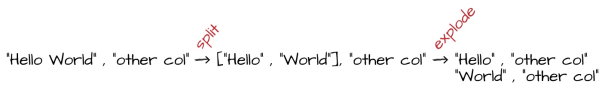

In [ ]:
from pyspark.sql.functions import split, explode

df.withColumn("splitted", split(col("Description"), " "))\
    .withColumn("exploded", explode(col("splitted")))\
    .select("Description", "InvoiceNo", "exploded").show(2, truncate=False)

# Equivalente em SQL:
# SELECT Description, InvoiceNo, exploded
# FROM (SELECT *, split(Description, " ") as splitted FROM dfTable)
# LATERAL VIEW explode(splitted) as exploded

### Maps

Maps são criados usando a função ```map``` e colunas com pares de chave-valor. Você pode então selecioná-los como você faria com um Array.

In [25]:
from pyspark.sql.functions import create_map, col
df.select(create_map(col("Description"), col("InvoiceNo")).alias("complex_map")).show(2, truncate=False)

# Equivalente em SQL:
# SELECT map(Description, InvoiceNo) as complex_map FROM dfTable
# WHERE Description IS NOT NULL

+----------------------------------------------+
|complex_map                                   |
+----------------------------------------------+
|[WHITE HANGING HEART T-LIGHT HOLDER -> 536365]|
|[WHITE METAL LANTERN -> 536365]               |
+----------------------------------------------+
only showing top 2 rows



''''''
Você pode consultá-los usando a chave apropriada. Uma chave ausente retorna nulo

df.select(map(col("Description"), col("InvoiceNo")).alias("complex_map")).selectExpr("complex_map['WHITE METAL LANTERN']").extract()


## JSON

O Spark tem algum suporte exclusivo para trabalhar com dados JSON. Você pode operar diretamente em strings de JSON no Spark e analisar sintáticamente a partir de JSON ou extrair objetos JSON.

In [30]:
jsonDF = spark.range(1).selectExpr("""'{"myJSONKey" : {"myJSONValue" : [1, 2, 3]}}' as jsonString""")

In [37]:
# Use o get_json_object para consultar em linha um objeto JSON, seja um dicionário ou uma Array.
# Use json_tuple se esse objeto tiver apenas um nível de aninhamento:

from pyspark.sql.functions import get_json_object, json_tuple
jsonDF.select(get_json_object(col("jsonString"), "$.myJSONKey.myJSONValue[1]").alias('column'),
              json_tuple(col("jsonString"), "myJSONKey")).show(2)

+------+--------------------+
|column|                  c0|
+------+--------------------+
|     2|{"myJSONValue":[1...|
+------+--------------------+



In [38]:
# Você também pode transformar um StructType em uma string JSON usando a função to_json:

from pyspark.sql.functions import to_json
df.selectExpr("(InvoiceNo, Description) as myStruct")\
    .select(to_json(col("myStruct")))

DataFrame[structstojson(myStruct): string]

Essa função também aceita um dicionário (_map_) de parâmetros que são os mesmos que a fonte de dados JSON. Você pode usar a função ```from_json``` para analisar isso (ou outros dados JSON) de volta. Isso naturalmente requer que você especifique um _schema_ e, opcionalmente, você pode especificar um _map_ de opções, também:

In [40]:
from pyspark.sql.functions import from_json
from pyspark.sql.types import *

parseSchema = StructType((StructField("InvoiceNo",StringType(),True),
    StructField("Description",StringType(),True)))

df.selectExpr("(InvoiceNo, Description) as myStruct")\
    .select(to_json(col("myStruct")).alias("newJSON"))\
    .select(from_json(col("newJSON"), parseSchema), col("newJSON")).show(2)

+----------------------+--------------------+
|jsontostructs(newJSON)|             newJSON|
+----------------------+--------------------+
|  [536365, WHITE HA...|{"InvoiceNo":"536...|
|  [536365, WHITE ME...|{"InvoiceNo":"536...|
+----------------------+--------------------+
only showing top 2 rows



## User-Defined Functions
<br>
<div style="text-align: justify">Uma das coisas mais poderosas que você pode fazer no Spark é definir suas próprias funções. As funções definidas pelo usuário (<b>UDFs</b>) permitem que você crie suas próprias transformações personalizadas usando Python ou Scala e até mesmo use bibliotecas externas. As UDFs podem receber e retornar uma ou mais colunas como entrada. As UDFs do Spark são incrivelmente poderosas porque você pode escrevê-las em várias linguagens de programação diferentes; você não precisa criá-los em um formato esotérico ou em uma linguagem específica do domínio. São apenas funções que operam nos dados, registro por registro.
<br><br>
Por padrão, essas funções são registradas como funções temporárias para serem usadas nesse <b>SparkSession</b> ou <b>Context</b>. Embora você possa escrever UDFs em Scala, Python ou Java, há considerações de desempenho que você deve conhecer. Para ilustrar isso, vamos analisar exatamente o que acontece quando você cria a UDF, passa para o Spark e executa o código usando essa UDF. O primeiro passo é a função atual. Vamos criar um simples para este exemplo.</div>

In [41]:
# Vamos escrever uma função power3 que eleve um  numero à potência de 3:
udfExampleDF = spark.range(5).toDF("num")

def power3(double_value):
    return double_value ** 3

power3(2.0)

8.0

### Nota: UDF em Spark 2.0 até 2.3
<br>
<div style="text-align: justify">Neste exemplo trivial, podemos ver que nossas funções funcionam como esperado. Somos capazes de fornecer uma entrada individual e produzir o resultado esperado. Até agora, nossas expectativas para a entrada são altas: ela deve ser um tipo específico e não pode ser um valor nulo. 
<br><br>
Agora que criamos essas funções e as testamos, precisamos registrá-las com o Spark para que possamos usá-las em todas as nossas máquinas de trabalho. O Spark serializará a função no driver e a transferirá pela rede para todos os processos do executor. Isso acontece independentemente da linguagem. 
<br><br> 
Quando você usa a função, existem essencialmente duas coisas diferentes que ocorrem. Se a função estiver escrita em Scala ou Java, você poderá usá-la na Java Virtual Machine (JVM). Isso significa que haverá pouca penalidade de desempenho, além do fato de que você não pode aproveitar os recursos de geração de código que o Spark possui para funções integradas. Pode haver problemas de desempenho se você criar ou usar muitos objetos.
<br><br>
Se a função for escrita em Python, algo bem diferente acontece. O Spark inicia um processo Python no worker, serializa todos os dados em um formato que o Python pode entender (lembre-se de que estava na JVM anterior), executa a função linha por linha nesses dados no processo Python e finalmente retorna os resultados das operações de linha para a JVM e o Spark.

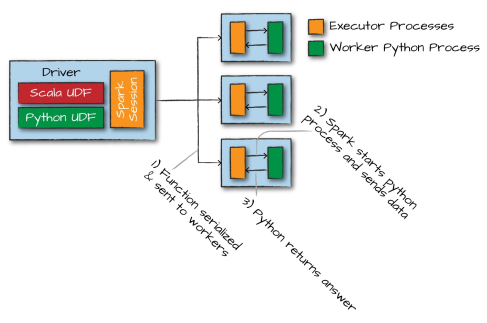

<div style="text-align: justify">Começar este processo de Python é caro, mas o custo real está em serializar os dados para o Python. Isso é caro por dois motivos: é uma computação cara, mas também, depois que os dados entram no Python, o Spark não consegue gerenciar a memória do worker. Isso significa que você poderia fazer com que um worker falhasse se os seus recursos fossem restritos (porque tanto a JVM quanto o Python estão competindo pela memória na mesma máquina). Recomendamos que você escreva suas UDFs em Scala ou Java - a pequena quantidade de tempo que você levará para escrever a função no Scala sempre gerará aumentos significativos de velocidade e, além disso, você ainda poderá usar a função do Python.</div>
<br>
Obs.: Esse processo de definição de funções UDF em Scala e execução com Python, será mostrado em um notebook a parte.

In [42]:
# Definindo a UDF
from pyspark.sql.functions import udf
power3udf = udf(power3)

In [43]:
# Chamando a UDF
from pyspark.sql.functions import col
udfExampleDF.select(power3udf(col("num"))).show(2)

+-----------+
|power3(num)|
+-----------+
|          0|
|          1|
+-----------+
only showing top 2 rows



Neste momento, podemos usar isso apenas como uma função DataFrame. Ou seja, não podemos usá-lo em uma expressão de string, apenas em uma expressão. No entanto, também podemos registrar essa UDF como uma função Spark SQL. Isso é valioso porque simplifica o uso dessa função no SQL, bem como em linguagens.

In [ ]:
# Registrando a função em Scala
spark.udf.register("power3", power3(_:Double):Double)
udfExampleDF.selectExpr("power3(num)").show(2)

Como essa função é registrada com o Spark SQL - e aprendemos que qualquer função ou expressão do Spark SQL é válida para  trabalhar com DataFrames - podemos usar o UDF que escrevemos no Scala, em Python. No entanto, em vez de usá-lo como uma função DataFrame, usamos como uma expressão SQL:

In [ ]:
# Função registrada em Scala
udfExampleDF.selectExpr("power3(num)").show(2)

<div style="text-align: justify">Também podemos registrar nossa função Python como uma função SQL e usá-la em qualquer linguagem. Uma coisa que também podemos fazer para garantir que nossas funções estejam funcionando corretamente é especificar um tipo de retorno. Como vimos no começo desta seção, o Spark gerencia suas próprias informações de tipo de dado, que não se alinham exatamente com os tipos do Python. 
<br><br>
Portanto, é uma boa prática definir o tipo de retorno para sua função ao definí-la. Se você especificar o tipo que não se alinha com o tipo real retornado pela função, o Spark não lançará um erro, mas retornará null para designar uma falha. Você pode ver isso se tiver que alternar o tipo de retorno na função a seguir para ser um <b>DoubleType</b>:</div>

In [ ]:
from pyspark.sql.types import IntegerType, DoubleType
spark.udf.register("power3py", power3, DoubleType())

udfExampleDF.selectExpr("power3py(num)").show(2)

Isso ocorre porque o intervalo cria números inteiros. Quando inteiros são operados em Python, o Python não os converte em flutuantes (o tipo correspondente ao tipo __double__ do Spark), portanto, vemos __null__. Podemos remediar isso garantindo que nossa função Python retorne um float em vez de um inteiro e que a função se comporte corretamente.

Você também pode usar a criação de UDF / UDAF por meio de uma sintaxe do Hive. Para permitir isso, primeiro você deve ativar o suporte ao Hive quando criar uma SparkSession:

In [ ]:
SparkSession.builder.EnableHiveSupport()

Então você pode registrar UDFs no SQL. Isso é compatível apenas com pacotes Scala e Java pré-compilados, portanto, você precisa especificá-los como uma dependência:

In [ ]:
# SQL:
CREATE TEMPORARY FUNCTION myFunc AS 'com.organization.hive.udf.FunctionName
# Além disso, você pode registrar isso como uma função permanente no Hive Metastore removendo o TEMPORARY.

Material baseado em exemplos do livro __Spark - The Definitive Guide. Bill Chambers e Matei Zaharia__